#Overview

In this script, we will look at the sensitivity of an option with regards to how the theoretical value changes when one variable is modified while keeping all other variables constant. 

In most experiments, we will plot the theoretical value on the y-axis. But rather than plotting the theoretical value itself, we will be using edge value instead (cost minus market price; from option buyer’s perspective, positive is favorable). Reason for this choice is because in many instances, options that are near-the-money tend to have higher market prices compared to theoretical value. I want to find the x-intercepts for visualizing these options, the logical reason for this is in the next paragraph. 

It’s not common to find mispriced options to Buy. In response to this phenomenon, I asked and imagined “what if the current spot price could magically rise or drop to a favorable value, if keeping all variables constant, then at what spot price(s) will I be indifferent to buying/selling the option(s)?” To approach this question, I’m deciding to plot the *Theoretical edge value v. Spot price*. The zero-intercepts on the x-axis tells us about the theoretically indifferent spot price. For a position that has multiple x-intercepts (as we will see below, for a straddle), it tells us about the theoretical break even intervals.


# Implementations (can skip to Application section) 



In [ ]:
!pip install yahoo_fin
from yahoo_fin import options

!pip install yfinance
import yfinance as yf

import time
import pandas as pd
from scipy.stats import norm

import math
from datetime import date

#### class BSM():

In [2]:
class BSM:
  
  def __init__(self, x, s,t,r,sigma):
    self.d1, self.d2 = None, None
    self.tv_call, self.delta_call , self.gamma_call, self.vega_call, self.theta_call, self.rho_call = None, None, None, None, None, None
    self.tv_put, self.delta_put, self.gamma_put, self.vega_put, self.theta_put, self.rho_put = None, None, None, None, None, None

    self.x = x
    self.s = s
    self.t = t
    self.r = r
    self.sigma = sigma
    self.calc()

  def calc(self):
    ''' Calculates all the theoretical and Greeks values for call and put. 
        Need to call calc() whenever new input is provided. 
    '''
    _a = math.log(self.s/ self.x)
    _b = (self.r+self.sigma**2/2)*self.t
    self.d1 = (_a+_b)/self.sigma*math.sqrt(self.t)
    self.d2 = self.d1 - self.sigma * math.sqrt(self.t)
    
    # Call: 
    self.tv_call    = self.s * norm.cdf(self.d1) - self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2)
    self.delta_call = norm.cdf(self.d1)
    self.gamma_call = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_call  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_call = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) - self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    self.rho_call   = 0.01*(self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    
    # Put: 
    self.tv_put    = self.x * math.exp(-self.r*self.t)-self.s+self.tv_call
    self.delta_put = -norm.cdf(-self.d1)
    self.gamma_put = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_put  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_put = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) + self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(-self.d2))
    self.rho_put   = 0.01*(-self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(-self.d2))



#### class contract():

In [3]:
class contract:

  def __init__(self, expiry_date, strike, contracttype, quoted_price):
    self.multiple = 100
    self.strike = strike
    self.contracttype=contracttype
    self.expiry_date = expiry_date
    self.price = quoted_price

  def __str__(self):
    return "{}_{}_{} @{}".format(self.expiry_date, self.strike, self.contracttype, self.price)

#### class leg():

In [4]:
class leg:

  def __init__(self, side, contract, size, date_today, s,r,sigma):
    self.size=size
    leg.size = size
    self.side = side
    t = (contract.expiry_date-date_today).days/365
    self.contract = contract
    self.model = BSM(contract.strike, s,t,r,sigma)

    self.delta = None
    self.rho = None
    self.vega = None
    self.theta = None   
    self.gamma = None
    self.edge = 0
    self.premium = 0

    # int _coefficient, has three purposes:
    #   (1) +/-ve Delta for long call/put, but it's reversed from seller's perspective  
    #   (2) If buyer of contract:   +ve vega, -ve theta, +ve gamma
    #   (3) If seller of contract:  -ve vega, +ve theta, -ve gamma
    _coefficient = None
    if self.side == "long":
      _coefficient = 1
    elif self.side == "short":
      _coefficient = -1
    
    if contract.contracttype=="call":
      if self.side == "long":
        self.edge = (self.model.tv_call-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_call) * size 
      self.delta = self.model.delta_call * size  * _coefficient
      self.rho = self.model.rho_call * size      * _coefficient
      self.vega = self.model.vega_call * size    * _coefficient
      self.gamma = self.model.gamma_call * size  * _coefficient
      self.theta = self.model.theta_call * size  * _coefficient
    
    elif contract.contracttype=="put":
      if self.side == "long":
        self.edge = (self.model.tv_put-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_put) * size 
      self.delta = self.model.delta_put * size   * _coefficient
      self.rho = self.model.rho_put * size       * _coefficient
      self.vega = self.model.vega_put * size     * _coefficient
      self.gamma = self.model.gamma_put * size   * _coefficient
      self.theta = self.model.theta_put * size   * _coefficient
    
    self.premium = contract.price * size * -_coefficient

  def __str__(self):
    n_round= 4 
    return "{} [x{}]: Δ={},𝚪={},Θ={},V={},⍴={}".format(str(self.contract),self.size, \
      self.delta.round(n_round),self.gamma.round(n_round),self.theta.round(n_round),self.vega.round(n_round),self.rho.round(n_round))


### class position():

In [5]:
class position:

  def __init__(self):
    self.list_leg = []
    
    self.total_delta = 0
    self.total_gamma = 0
    self.total_vega = 0
    self.total_theta = 0
    self.total_rho = 0
    self.total_premium = 0
    self.total_th_edge = 0

  def get_summary(self, rounding=4) -> dict:
    ''' Returns dict of {string:float}
    '''
    return {"Total delta" : round(self.total_delta,rounding),
            "Total gamma" : round(self.total_gamma,rounding),
            "Total vega"  : round(self.total_vega,rounding),
            "Total theta" : round(self.total_theta,rounding),
            "Total rho"   :round(self.total_rho,rounding),
            "Premium (paid)/received" : round(self.total_premium,rounding),
            "Th. Edge"    : round(self.total_th_edge,rounding),
            }
  
  def add_leg(self, leg):
    ''' @param leg
    '''
    size = leg.size
    self.total_premium += leg.premium
    self.total_th_edge += leg.edge
    self.list_leg.append(leg)
    
    self.total_delta += leg.delta
    self.total_gamma += leg.gamma
    self.total_vega += leg.vega
    self.total_theta += leg.theta
    self.total_rho += leg.rho 


### Other Methods :

Including code blocks for processing data

In [6]:
def populate_dict(yf_chain, contracttype):
  ''' @param Object yf_chain : from options.get_options_chain(symbol, date_expire_str)["calls" or "puts"]
      @param string contracttype : either "call" or "put
      Returns a dict of {float strike price : contract object}
  '''
  out = {}
  for i in range(len(yf_chain)):
    x = yf_chain["Strike"][i]
    out[x] = contract(date_expire, x, contracttype, yf_chain["Last Price"][i])
  return out


###Plotting sensitivity

Theoretical value vs Spot

In [38]:
def sensit_edge_v_spot(initial_spot, step_spot, step_range_multiplier):
  ''' @param float initial_spot
      @param float step_spot, in absolute amount
      @param float step_range_multiplier, ie. range(-10,10) of step $1 means +/-$10
  '''
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _spot = crnt_price-i*step_spot

    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)
    
    list_x.append(_spot)
    _edge = tmp_pos.total_th_edge 
    if __tmp is not None and ((_edge > 0 and __tmp < 0) or (_edge < 0 and __tmp > 0)):
      list_zerocross.append(_spot.round(2))
    list_y.append(_edge)
    __tmp = _edge

  pd.DataFrame({ "Spot":list_x, "Theoretical edge":list_y} ).plot(x="Spot", y="Theoretical edge" )
  list.sort(list_zerocross)
  print("Theoretical edge exists when price of underlying\n asset is out of price interval " + str(tuple(list_zerocross)) )

Theoretical value vs Sigma

In [30]:
def sensit_edge_v_sigma(initial_spot, initial_sigma, step_sigma, step_range_multiplier, clip=True):
  ''' @param float initial_spot
      @param float initial_sigma
      @param float step_sigma, in absolute amount
      @param float step_range_multiplier 
      @param bool clip, to clip off negative values
  '''
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _sigma = sigma + i*step_sigma
    tmp_pos = position() 

    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=initial_spot, r=riskfree_rate, sigma=_sigma)
      tmp_pos.add_leg(_leg)

    _edge = tmp_pos.total_th_edge
    list_x.append(_sigma)
    if __tmp is not None and ((_edge > 0 and __tmp < 0) or (_edge < 0 and __tmp > 0)):
      list_zerocross.append(_sigma)
    __tmp = _edge
    list_y.append(_edge)

  df = pd.DataFrame({ "Sigma":list_x, "Theoretical Edge":list_y } )
  if clip:
    df = df[df["Theoretical Edge"]>0] 
  print("X-intercepts (sigma): " + str(list_zerocross))
  df.plot(x="Sigma", y="Theoretical Edge");

Delta vs Spot

In [9]:
def sensit_delta_v_spot(initial_spot, step_spot, step_range_multiplier):
  ''' @param float initial_spot
      @param float step_spot, in absolute amount
      @param float step_range_multiplier 
      @param bool clip, to clip off negative values
  '''
  list_x, list_y = [], []

  for i in step_range_multiplier:
    _spot = crnt_price + i*step_spot
    tmp_pos = position() 

    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)

    list_x.append(_spot)
    list_y.append(tmp_pos.total_delta)

  df = pd.DataFrame({ "Spot":list_x, "Delta":list_y } ) 
  df.plot(x="Spot", y="Delta");

#Application: 

In [10]:
# 😎 Manual inputs:
symbol                   = "KO" 
sigma                    = 0.14 
riskfree_rate            = math.e**(.0393)-1
date_today               = date(2023,2,28) 
date_expire              = date(2023,3,17)

# Obtaining the recent close and confirming expiration date (above) is valid
data = yf.Ticker(symbol).history()
crnt_price = data['Close'].iloc[-1] 
date_expire_str = date_expire.strftime("%B %d, %Y") 
assert date_expire_str in options.get_expiration_dates(symbol) 
calls = populate_dict(options.get_options_chain(symbol, date_expire_str)["calls"], "call")
puts = populate_dict(options.get_options_chain(symbol, date_expire_str)["puts"], "put")

# 😎 Manual inputs:
# Example: Buying a straddle
legs = (\
        leg(side="long", contract=calls[60], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma),
        leg(side="long", contract=puts[60], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma)\
        )

pos = position()
for e in legs:
  pos.add_leg(e)



#Sensitivity Analysis 

In [21]:
"Current price of " + symbol + ": " + str(crnt_price.round(2))

'Current price of KO: 59.51'

###Option's value v. Spot price

Theoretical edge exists when price of underlying
 asset is out of price interval (55.26, 64.26)


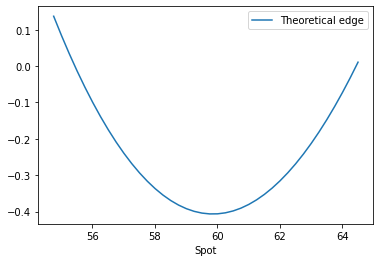

In [39]:
sensit_edge_v_spot(crnt_price, step_spot=0.25, step_range_multiplier=range(-20,20))

**Observations:** Ideally, if the price is outside of interval (x1, x2) as printed above, keeping all other variables constant, then there will be an edge for this position. However, these areas are very far away when considering both historical volatility (using EWMA estimator on Daily, t=252) and IV to be low, only around 14%. 

The premiums paid for near-the-money options expiring in mid-March for KO is rather expensive, I would rather sell calls and puts instead of buying them. Of course, as Seller, I can be wrong about implied volatility. If IV makes a violent spike upwards, then I’m in trouble (assuming I take no other actions to hedge my downsides). 

**Next question:** By how much volatility should IV spike towards in order for Buyers to benefit, but on the flip side for Sellers to suffer? 

To answer this question, we will look at: *Option's value v. Sigma*




###Option's value v. Sigma (when near-the-money)

X-intercepts (sigma): [0.18000000000000002]


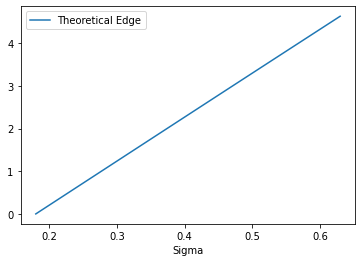

In [31]:
sensit_edge_v_sigma(crnt_price, sigma, step_sigma=0.01, step_range_multiplier=range(-10,50))

Based on this plot:

> **Interpretation #1:** As Buyer of the straddle, we want volatility to increase to around 0.18. If all other variables are constant, then our Long straddle will begin to have a theoretical edge. 

> **Interpretation #2:** As Seller of the straddle, being on the opposite side, we want volatility to sit still. When the options expire out of the money, we as the seller won't get assigned to fulfilling the terms of the contracts, premiums previously received become crystalized profits. For this to happen, it's best to see volatility being as low as possible. If implied volatility increases to 0.18, then it is a red flag. 

###Option's value v. Sigma when deeply ITM

As seen in the previous example, when strike price is near-the-money, the curve (Theoretical value based on f(Sigma)) is very close to being a straight line. However, the curvature becomes more evident when the option is deeply in/out of the money. 

To illustrate the point, suppose price tanks by 50% (=crnt_price/2). 

**Buyer's perspective** As buyer of straddle who already owns the position prior to the imaginery 50%-drop, the best case scenario is for volatility to stay low until expiration when the 60 put becomes exercisable.

X-intercepts (sigma): []


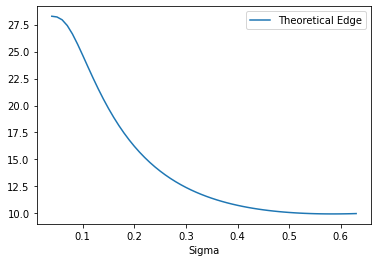

In [32]:
sensit_edge_v_sigma(crnt_price/2, sigma, step_sigma=0.01, step_range_multiplier=range(-10,50))

###Delta v. Spot price

In a perfect world, a straddle is delta neutral when both calls and puts are at-the-money and have Deltas of +/- 50s (+/- 50s cancel out). 

We know this can't happen because market conditions are always changing. Even in theory, we can see that deltas of calls and puts at the same strike price do not completely cancel out. This brings the questions: "Should be remain delta neutral when price goes up and down by a dollar?"

Let's answer this with a plot.




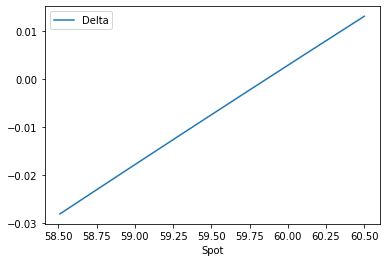

In [37]:
sensit_delta_v_spot(crnt_price, step_spot=.01, step_range_multiplier=range(-100,100))

>**Interpretation about this plot:** As spot prices make a steady move below/above 60 strike (Using the word "steady" because we are holding sigma and vega constant) we get exposed to a little bit of delta. 

For a dollar-drop, our delta becomes negative 0.03, so we will need to buy 3 underlying shares to remain delta neutral; the opposite is to short 1 share when there is a $1 increase in price. 

It is impractical to make delta neutral adjustments repeatedly until maturity to maintain delta neutrality. For every minor adjustment made, it does not affect PL much, but transaction costs to execute these orders, and also time costs to monitor these adjustments outweigh potential gains.

Practical responses to seeing Delta changing with respect Spot: (A) decide on a frequency to make delta neutral adjustments, or (B) Don’t adjust it, accept some directional risks, have a threshold for amount of +/- deltas as part of overall risk parameters for a portfolio of options. 





